#Training YOLOv5 on Custom Dataset
Thanks to [Roboflow](https://roboflow.com),[YOLOv5 repository](https://github.com/ultralytics/yolov5) by [Ultralytics](https://www.ultralytics.com/)

Steps:

* Creating Custom dataset in format which YOLO understands
* Installing YOLOv5 dependencies
* Writing our YOLOv5 Training configuration
* Running YOLOv5 training
* Evaluating YOLOv5 performance
* Visualizing YOLOv5 training data
* Running YOLOv5 inference on test images
* Exporting saved YOLOv5 weights for future inference

#Installing Dependencies


In [1]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
!git reset --hard 064365d8683fd002e9ad789c1e91fa3d021b44f0

fatal: destination path 'yolov5' already exists and is not an empty directory.
/content/yolov5
HEAD is now at 064365d Update parse_opt() in export.py to work as in train.py (#10789)


In [2]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.downloads import attempt_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 2.0.1+cu118 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15101MB, multi_processor_count=40)


# Importing Correctly Formatted Custom Dataset

We'll make our dataset using Roboflow. Use the "**YOLOv5 PyTorch**" export format.The Ultralytics implementation calls for a YAML file defining where your training and test data is. The Roboflow export also writes this format for us.

In [5]:
#follow the link below to get your download code from from Roboflow
!pip install roboflow
%cd /content/yolov5

from roboflow import Roboflow
rf = Roboflow(api_key="7BX97jSmDLxn9AN7gwzq")
project = rf.workspace("kumar-abhishek-of9sh").project("chess-tz026")
dataset = project.version(1).download("yolov5")

/content/yolov5
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to chess-1 in yolov5pytorch:: 100%|██████████| 176/176 [00:00<00:00, 1518.71it/s]


In [6]:
# this is the YAML file Roboflow wrote for us that we're loading into this notebook with our data
%cat {dataset.location}/data.yaml

names:
- Kingrotation
- Knightrotation
- Pawnrotation
- Queenrotation
- bishoprotation
- rookrotation
nc: 6
roboflow:
  license: CC BY 4.0
  project: chess-tz026
  url: https://universe.roboflow.com/kumar-abhishek-of9sh/chess-tz026/dataset/1
  version: 1
  workspace: kumar-abhishek-of9sh
test: ../test/images
train: chess-1/train/images
val: chess-1/valid/images


# Defining Model Configuration and Architecture

In [7]:
# define number of classes based on YAML
import yaml
with open(dataset.location + "/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [8]:
#this is the model configuration we will use for our tutorial
%cat /content/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [9]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [10]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

# Training Custom YOLOv5 Detector

### Next, we'll fire off training!


Here, we are able to pass a number of arguments:
- **img:** define input image size
- **batch:** determine batch size
- **epochs:** define the number of training epochs. (Note: often, 3000+ are common here!)
- **data:** set the path to our yaml file
- **cfg:** specify our model configuration
- **weights:** specify a custom path to weights. (Note: you can download weights from the Ultralytics Google Drive [folder](https://drive.google.com/open?id=1Drs_Aiu7xx6S-ix95f9kNsA6ueKRpN2J))
- **name:** result names
- **nosave:** only save the final checkpoint
- **cache:** cache images for faster training

In [11]:
# train yolov5s on custom data for 100 epochs
# time its performance
%%time
%cd /content/yolov5/
!python train.py --img 640 --batch 16 --epochs 8000 --data {dataset.location}/data.yaml --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache

Streaming output truncated to the last 5000 lines.
      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
   386/7999      3.74G    0.04068     0.1152    0.02697        458        640: 100% 5/5 [00:01<00:00,  2.88it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 1/1 [00:00<00:00,  7.05it/s]
                   all          2         54      0.303      0.951      0.634      0.369

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
   387/7999      3.74G    0.03922     0.1163    0.02737        380        640: 100% 5/5 [00:01<00:00,  4.16it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 1/1 [00:00<00:00,  9.74it/s]
                   all          2         54      0.314      0.958      0.558      0.312

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
   388/7999      3.74G    0.04615     0.1201    0.02746      

# Evaluating Custom YOLOv5 Detector Performance

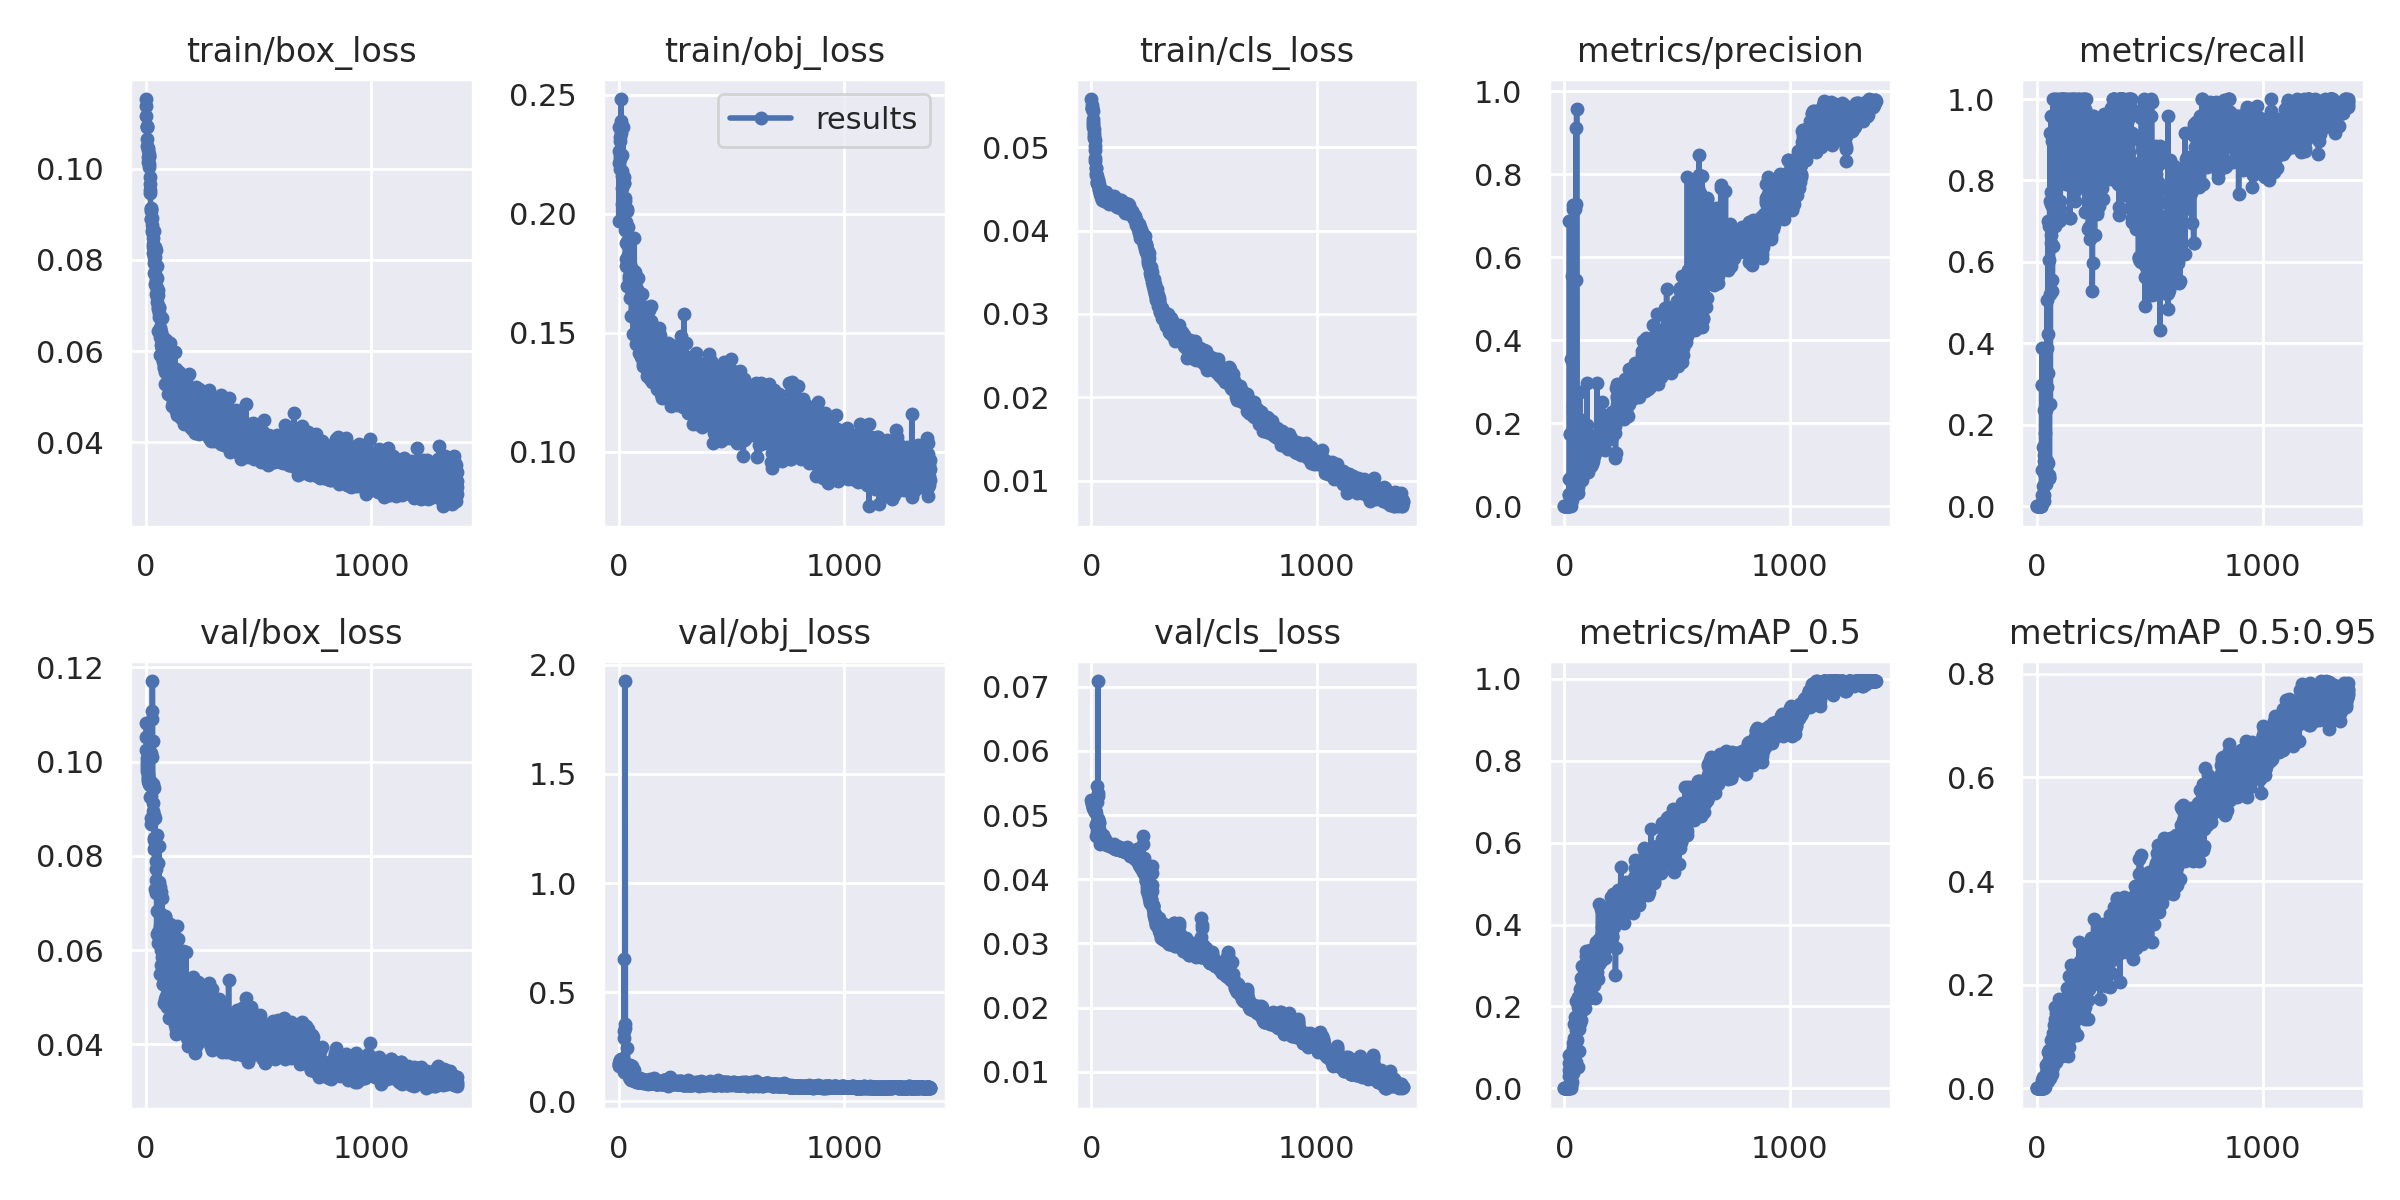

In [12]:
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/yolov5s_results/results.png', width=1000)  # view results.png

GROUND TRUTH TRAINING DATA:


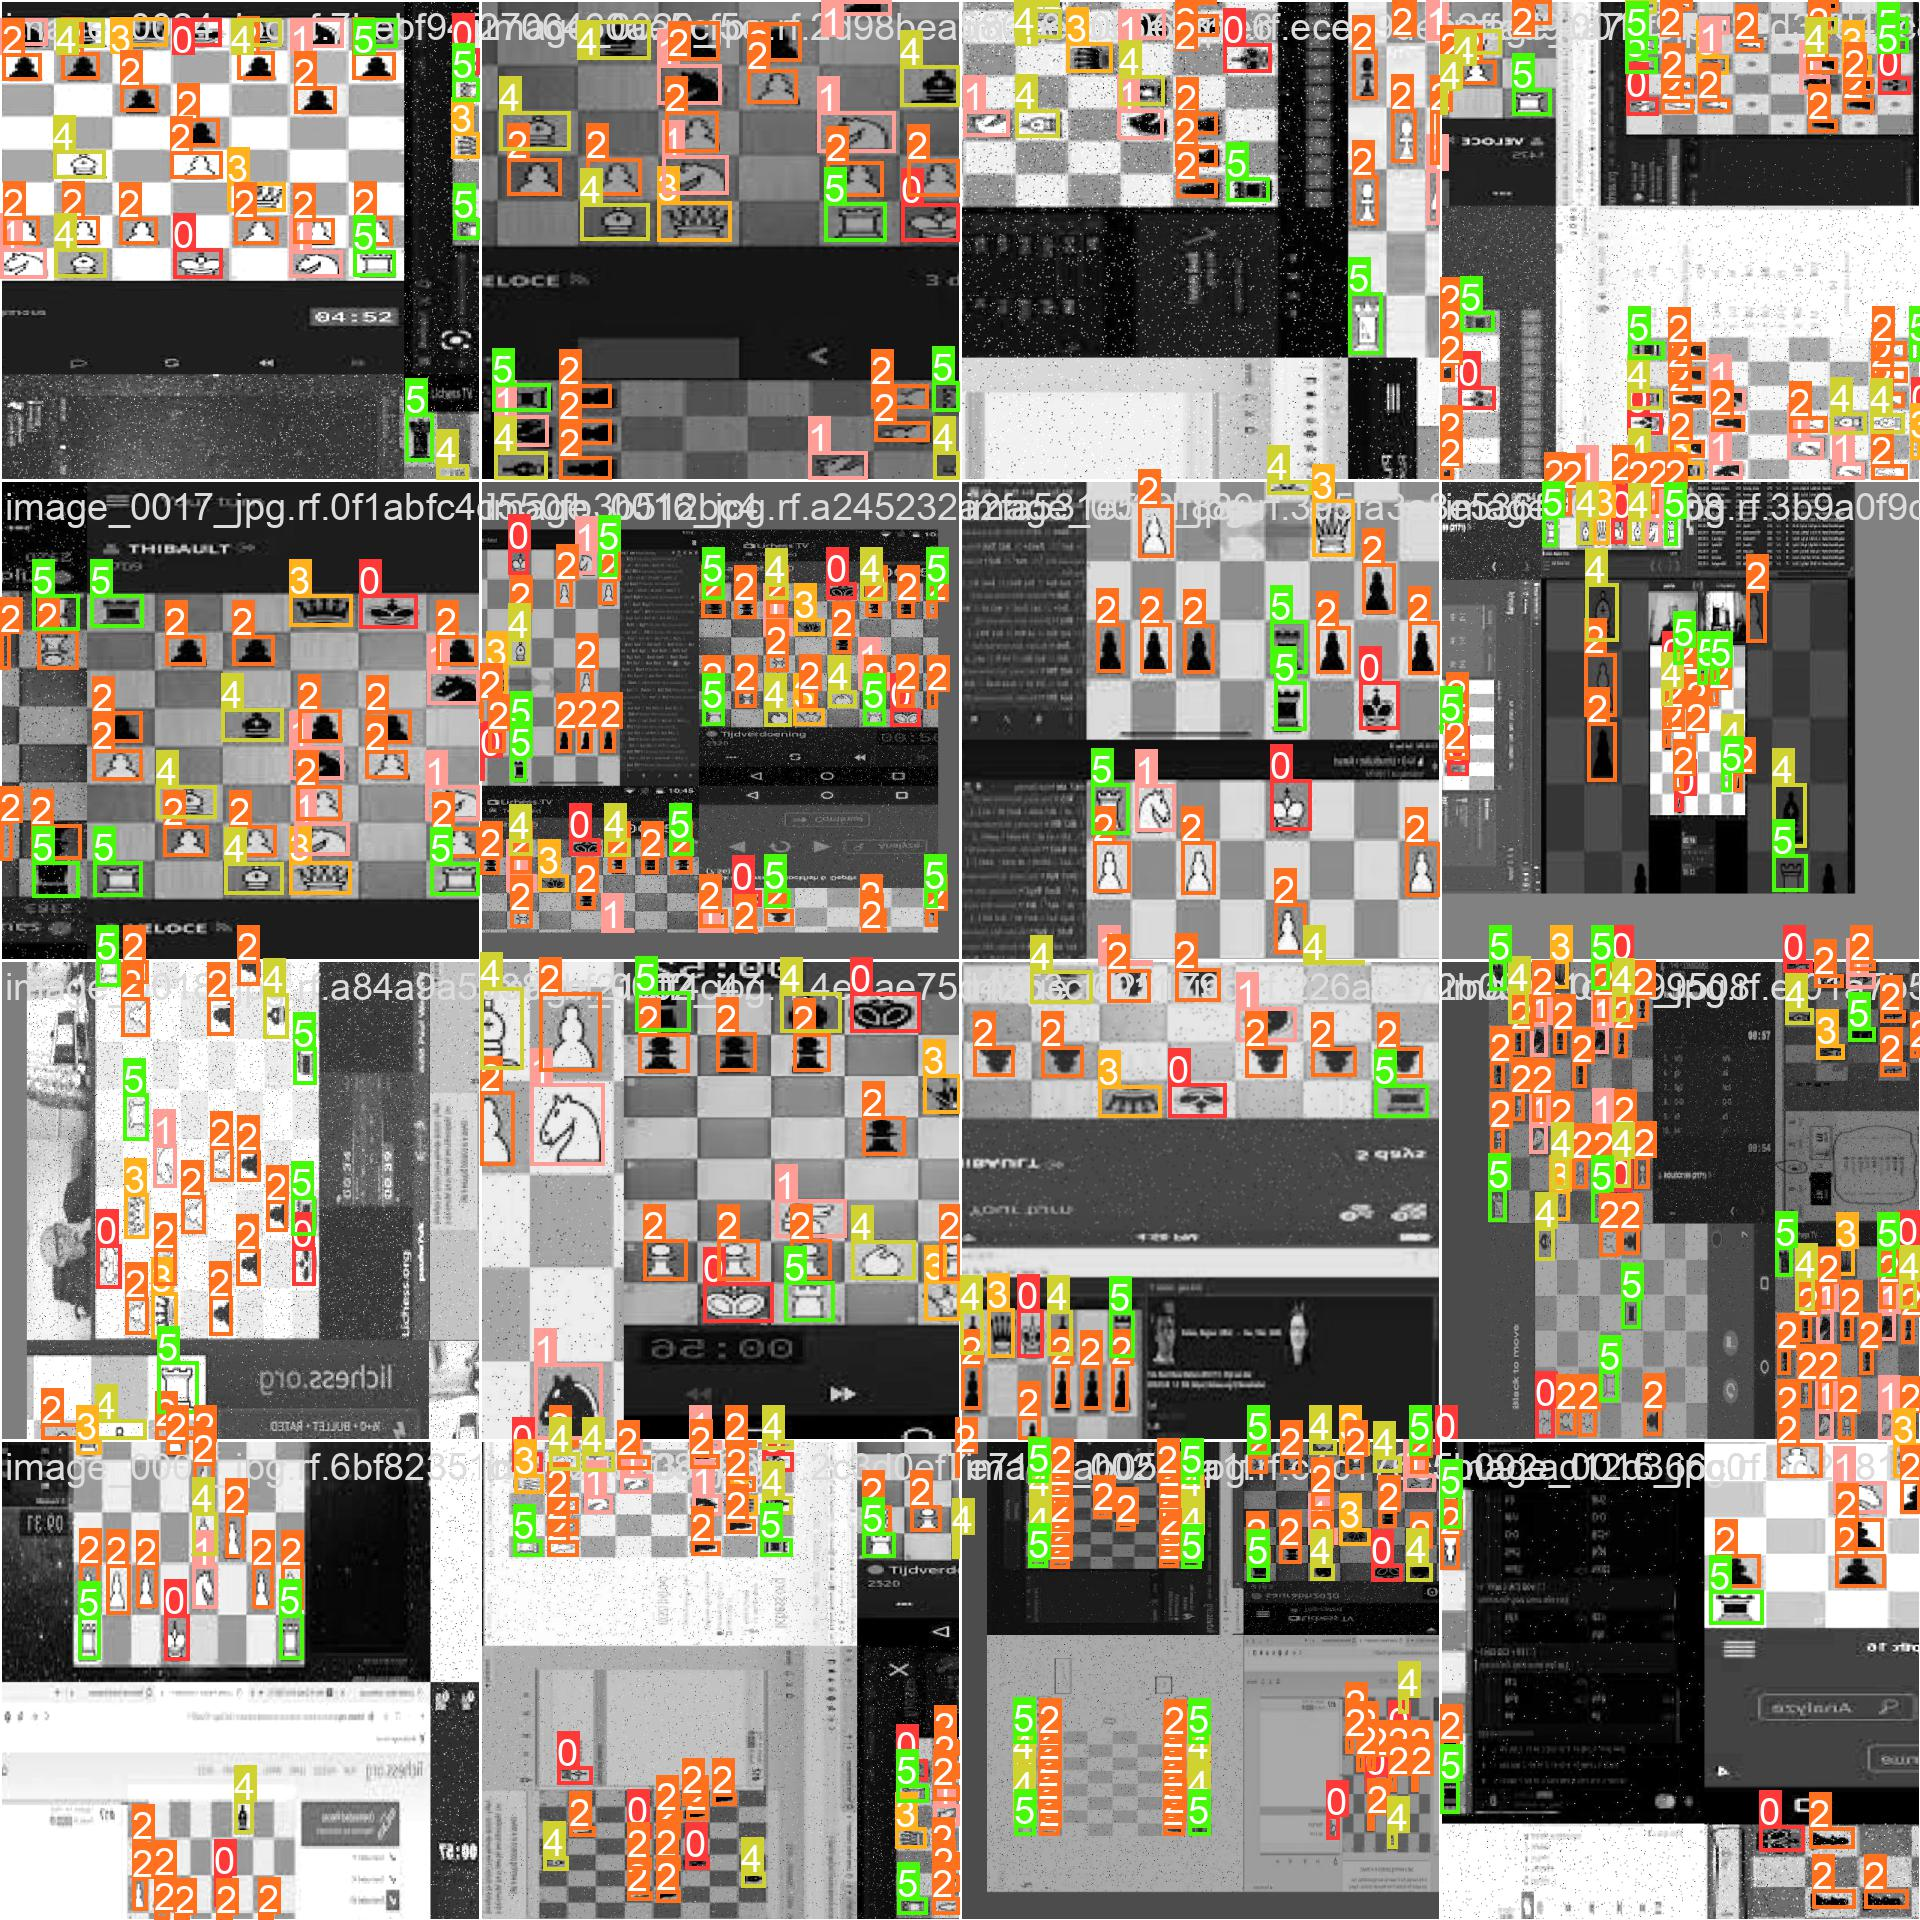

In [13]:
# first, display our ground truth data
print("GROUND TRUTH TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/train_batch0.jpg', width=900)

GROUND TRUTH AUGMENTED TRAINING DATA:


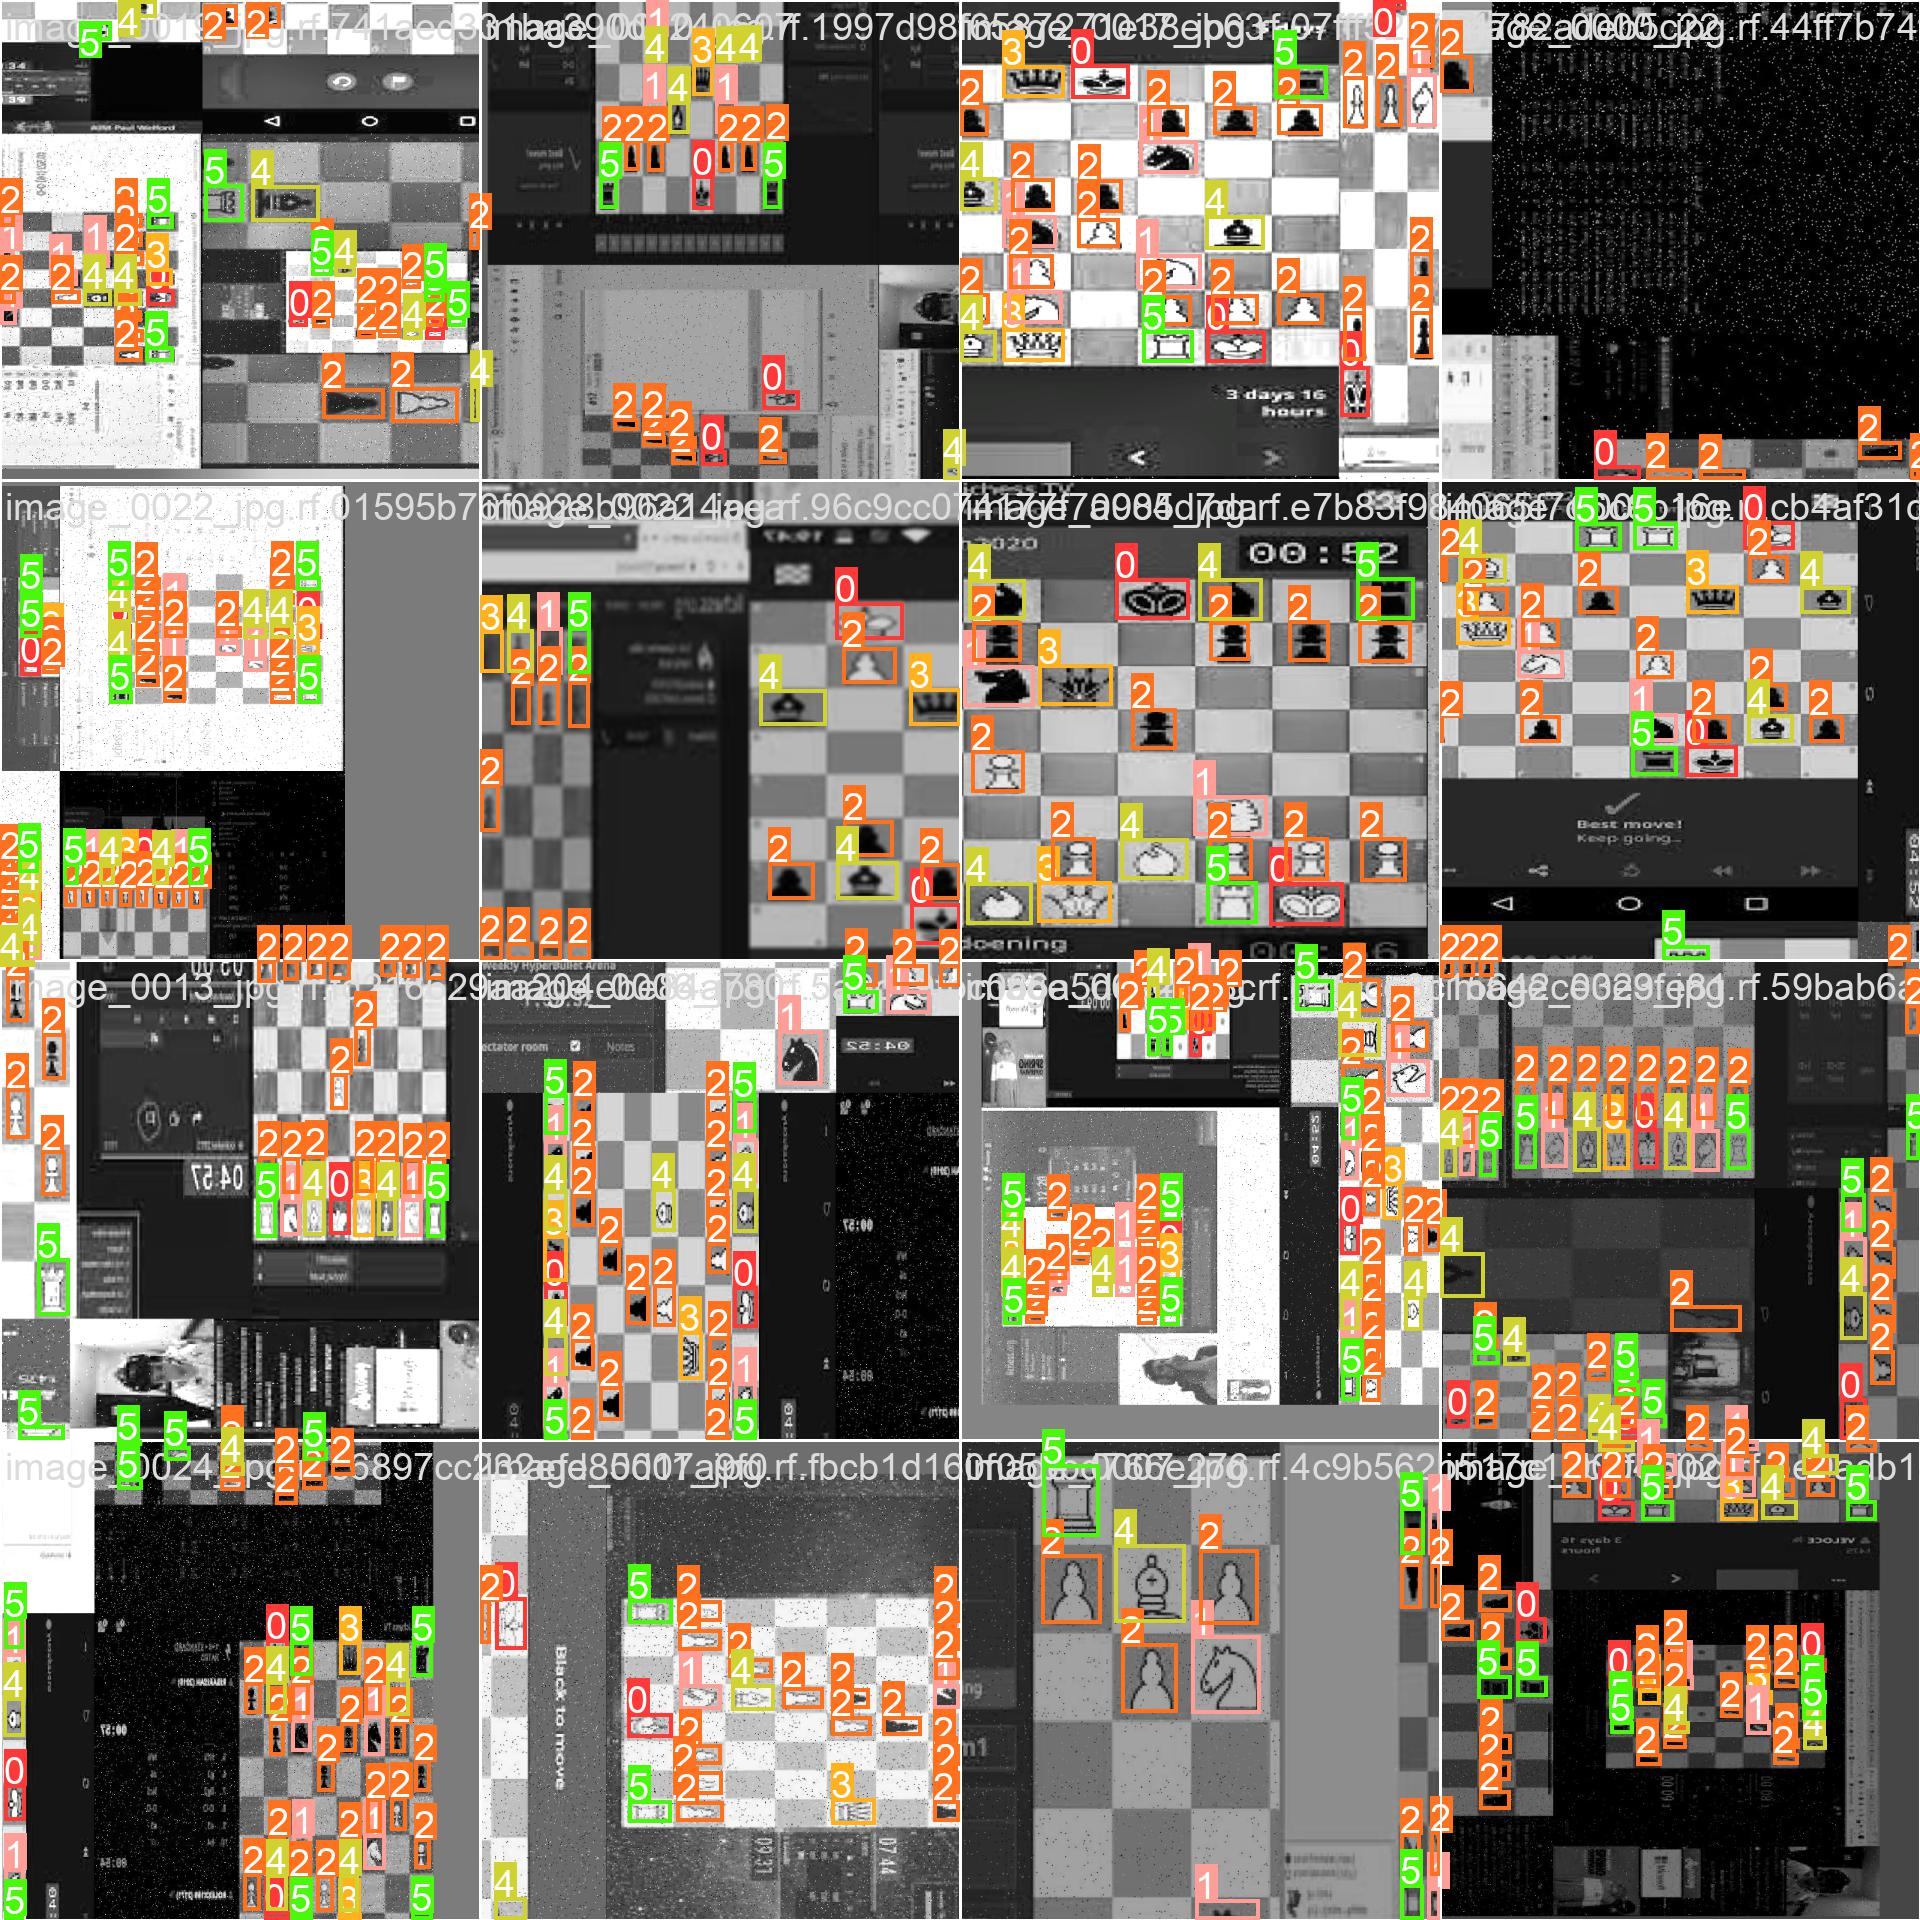

In [14]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/train_batch1.jpg', width=900)

#Running Inference  With Trained Weights

In [15]:
# trained weights are saved by default in our weights folder
%ls runs/

train/


In [17]:
%ls runs/train/yolov5s_results/weights

best.pt  last.pt


In [25]:
# when we ran this, we saw .007 second inference time. That is 140 FPS on a TESLA P100!
# use the best weights!
%cd /content/yolov5/
!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 640 --conf 0.4 --source "/content/chess2.png"

/content/yolov5
detect: weights=['runs/train/yolov5s_results/weights/best.pt'], source=/content/chess2.png, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-72-g064365d Python-3.10.6 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7260003 parameters, 0 gradients
image 1/1 /content/chess2.png: 320x640 2 Kingrotations, 1 Knightrotation, 2 Queenrotations, 1 rookrotation, 77.1ms
Speed: 0.7ms pre-process, 77.1ms inference, 102.6ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp3


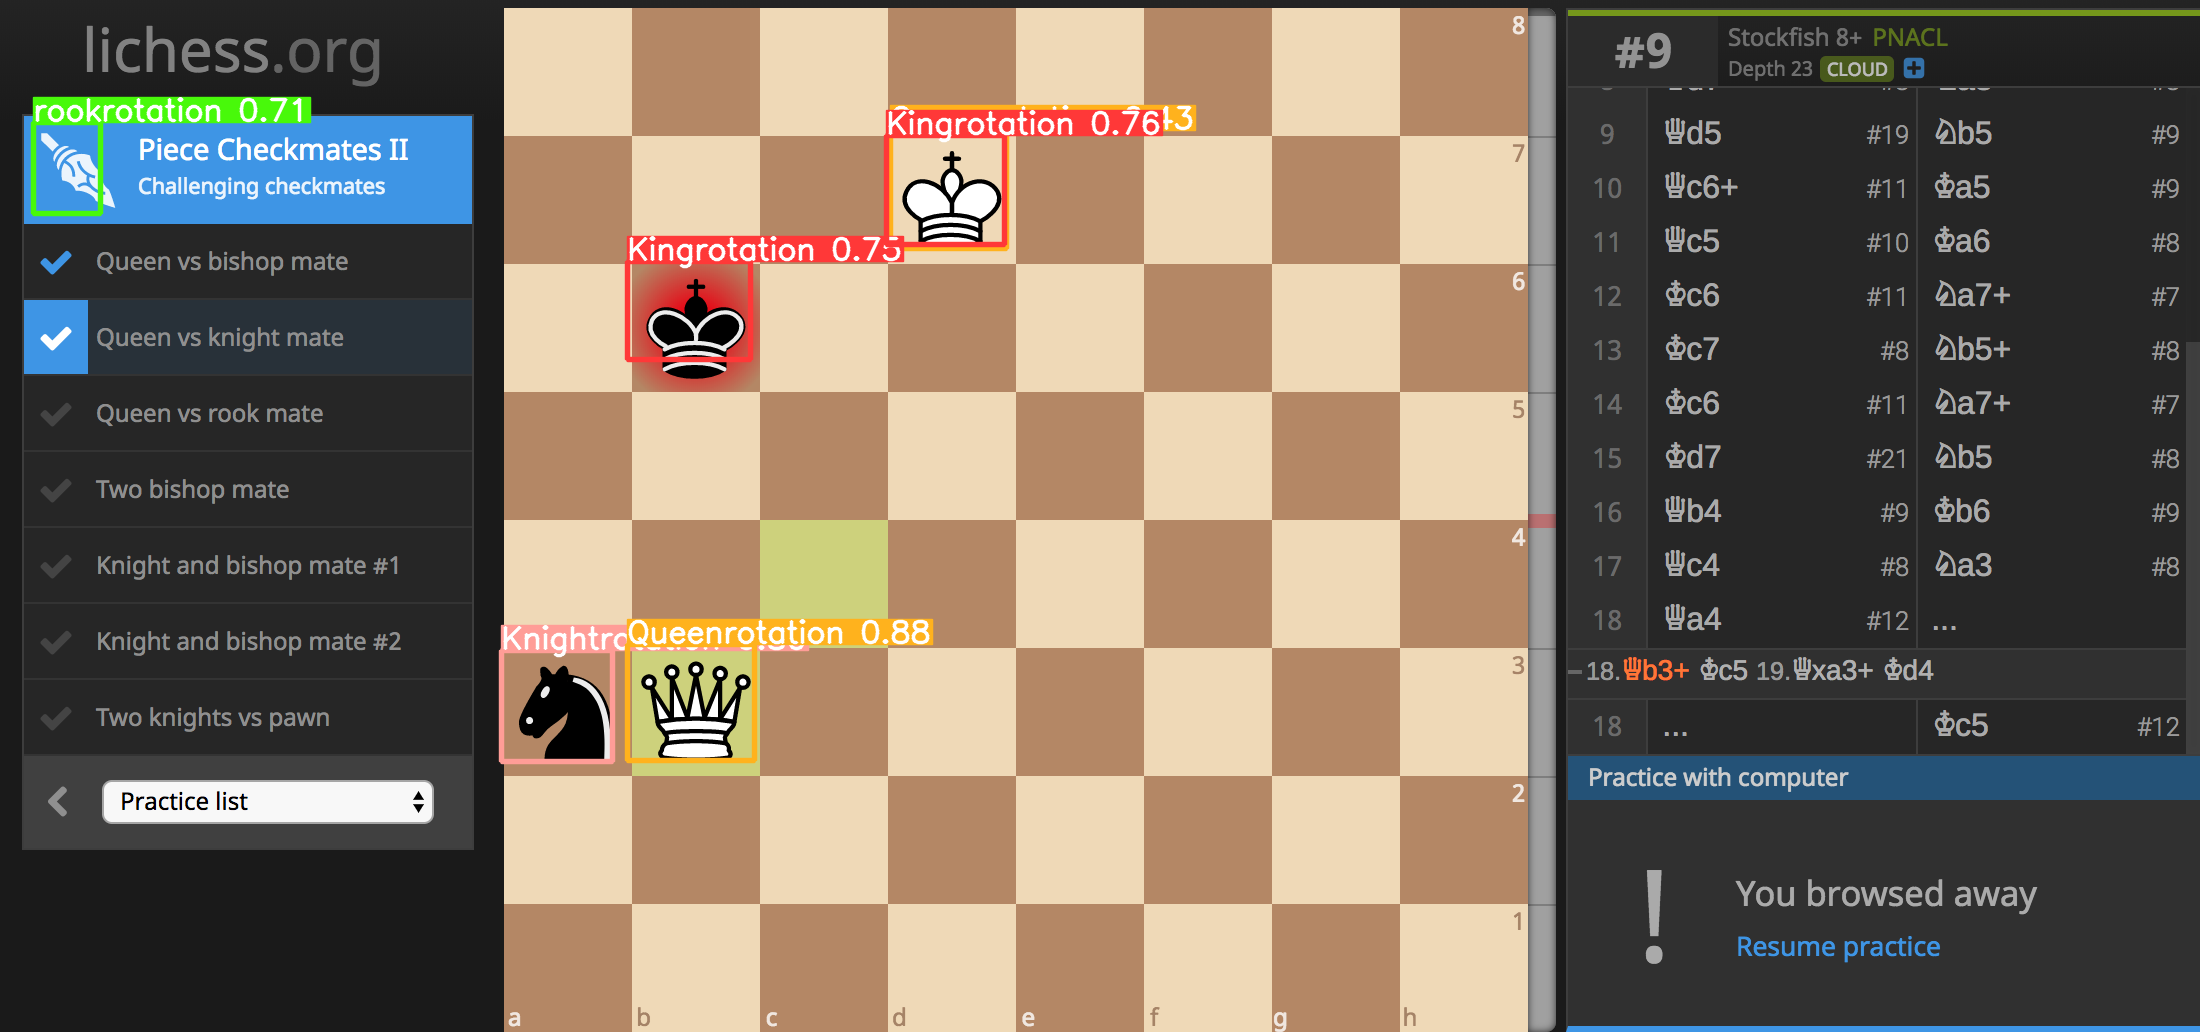

In [26]:
#display inference on ALL test images
#this looks much better with longer training above

import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp3/*.png'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

# Saving Weights in drive for future use

In [20]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [21]:
%cp /content/yolov5/runs/train/yolov5s_results/weights/best.pt /content/gdrive/My\ Drive

###### [Reference](https://towardsdatascience.com/how-to-train-a-custom-object-detection-model-with-yolo-v5-917e9ce13208)